# Importing necessary library files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
#import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [3]:
np.random.seed(0)

## Generate data

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


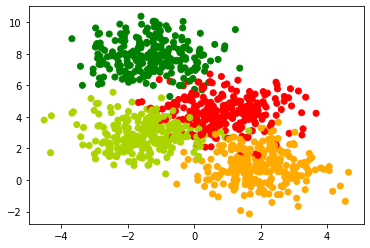

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

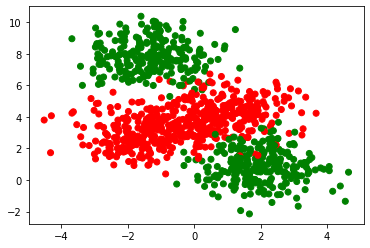

In [7]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Multi class classification

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [9]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [10]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


## Input + Weight Vectorised Version

In [11]:
class FF_MultiClass_InputWeightVectorised:
  
  def __init__(self, W1, W2):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))
  
  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X):
    self.A1 = np.matmul(X,self.W1) + self.B1 # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.sigmoid(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
    
  def grad_sigmoid(self, X):
    return X*(1-X) 
  
  def grad(self, X, Y):
    self.forward_pass(X)
    m = X.shape[0]
    
    self.dA2 = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    
    self.dW2 = np.matmul(self.H1.T, self.dA2) # (2, N) * (N, 4) -> (2, 4)
    self.dB2 = np.sum(self.dA2, axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.dH1 = np.matmul(self.dA2, self.W2.T) # (N, 4) * (4, 2) -> (N, 2)
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    
    self.dW1 = np.matmul(X.T, self.dA1) # (2, N) * (N, 2) -> (2, 2)
    self.dB1 = np.sum(self.dA1, axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

      
  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      self.grad(X, Y) # X -> (N, 2), Y -> (N, 4)
        
      m = X.shape[0]
      self.W2 -= learning_rate * (self.dW2/m)
      self.B2 -= learning_rate * (self.dB2/m)
      self.W1 -= learning_rate * (self.dW1/m)
      self.B1 -= learning_rate * (self.dB1/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

# Time Taken by model and result of train & validation accuracy

C:\Users\USER\AppData\Local\Temp/ipykernel_12308/1104452991.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

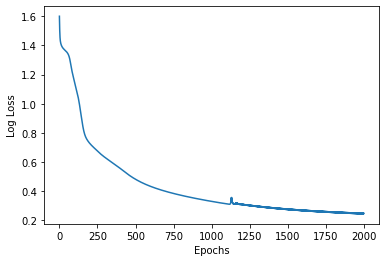

Time taken by Input + Weight Vectorised Version 


In [12]:
models_init = [FF_MultiClass_InputWeightVectorised(W1, W2)]
models = []
for idx, model in enumerate(models_init, start=1):
  tic = time.time()
  ffsn_multi_specific = model
  ffsn_multi_specific.fit(X_train,y_OH_train,epochs=2000,learning_rate=.5,display_loss=True)
  models.append(ffsn_multi_specific)
  toc = time.time()
  print("Time taken by Input + Weight Vectorised Version ".format(idx, toc-tic))

In [13]:
  Y_pred_train = model.predict(X_train)
  Y_pred_train = np.argmax(Y_pred_train,1)

  Y_pred_val = model.predict(X_val)
  Y_pred_val = np.argmax(Y_pred_val,1)

  accuracy_train = accuracy_score(Y_pred_train, Y_train)
  accuracy_val = accuracy_score(Y_pred_val, Y_val)
  
  print("Model Input + Weight Vectorised Version".format(idx))
  print("Training accuracy", round(accuracy_train, 2))
  print("Validation accuracy", round(accuracy_val, 2))

Model Input + Weight Vectorised Version
Training accuracy 0.91
Validation accuracy 0.92


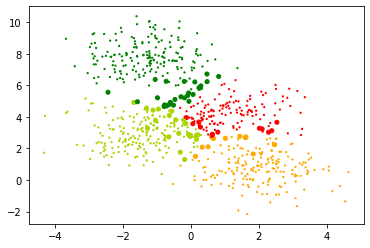

In [14]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
plt.show()